## Task 3: Predictive Analysis - WIP
Consider the problem of predicting for each incident (considering the whole dataset for this task) the label which is a **binary variable** that indicates if in the incident there have been at least a killed person or not.


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py


# Set a seed for reproducibility
np.random.seed(42)



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import the datasets

# Gun incidents data
df_incidents_cleaned = pd.read_hdf('../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64   

In [3]:

df_incidents_dt = df_incidents_cleaned.copy()
#df_incidents_dt['n_participant_adult'] = (df_incidents_dt['n_participants'] - (df_incidents_dt['n_participants_child'] + df_incidents_dt['n_participants_teen'])).astype('int')


<AxesSubplot:title={'center':'Percentage of incidents with killed people'}, ylabel='isKilled'>

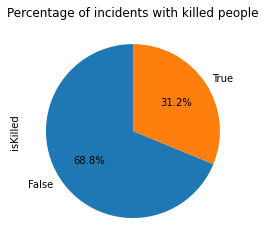

In [4]:
df_incidents_dt['isKilled'] = df_incidents_dt['n_killed'] > 0
df_incidents_dt['isKilled'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title = 'Percentage of incidents with killed people')


In [5]:
coumns_not_to_drop_dt = ['isKilled', 'n_arrested', 'n_females',
                         'avg_age_participants', 'povertyPercentage', 
                         'density_incident_state', 'state', 'n_injured']

# broke all if you add n_killed since is higly correlated : 0.94

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131618 entries, 0 to 134578
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   state                   131618 non-null  object 
 1   avg_age_participants    131618 non-null  int64  
 2   n_females               131618 non-null  int64  
 3   n_injured               131618 non-null  int64  
 4   n_arrested              131618 non-null  int64  
 5   povertyPercentage       131618 non-null  float64
 6   density_incident_state  131618 non-null  float64
 7   isKilled                131618 non-null  bool   
dtypes: bool(1), float64(2), int64(4), object(1)
memory usage: 8.2+ MB


In [6]:

columns_to_drop_dt = ['longitude',
                   'latitude', 
                   'congressional_district',
                   'participant_age_group1',
                   'participant_gender1',
                   'incident_characteristics1',
                   'city_or_county',
                   'date',
                   'n_injured',
                   'party',
                   'candidatevotes',
                   'totalvotes',
                   'n_killed',
                   'ratio_killed'
                   ]


/tmp/ipykernel_321272/458054139.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



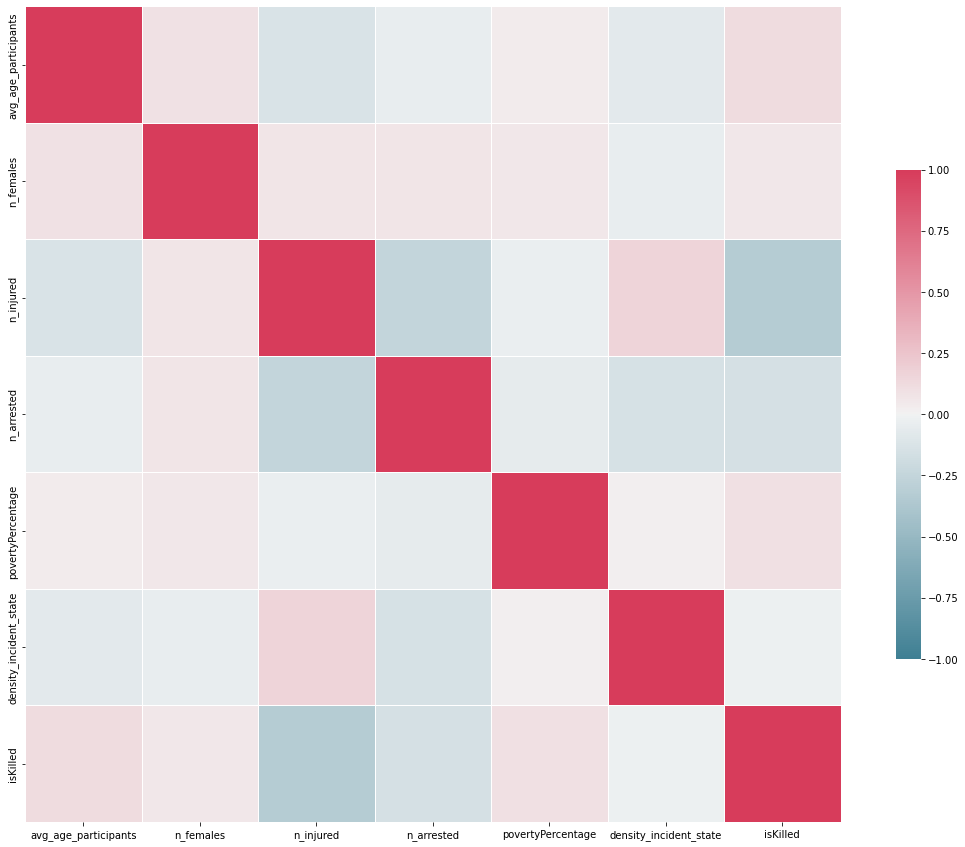

In [7]:
def plot_correlation(df_columns, df):
    
    # Compute the correlation matrix
    corr = df[df_columns].corr()

    # Generate a mask for the upper triangle
    #do not use np.bool is deprecated
    mask = np.zeros_like(corr, dtype=bool)
     
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 15))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 5, as_cmap=True)

    # Put numbers in squares that have correlation > 0.5 or < -0.5
    # Iterate over the correlation matrix and get the columns indices
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if (corr.iloc[i, j] > 0.5 or corr.iloc[i, j] < -0.5) and i != j:
                # put text in square
                ax.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6})
    
plot_correlation(df_incidents_dt.columns, df_incidents_dt)


### Decision Tree

In [8]:

# max number of df_incident_dt where isKilled is True
max_killed = df_incidents_dt['isKilled'].value_counts()[1]

print('max_killed: ', max_killed)

max_killed:  41078


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_incidents_cleaned is your original DataFrame

UMBALANCE_DATA = False

if not UMBALANCE_DATA:

    # Select 100 samples where isKilled is True
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=40000, random_state=42)

    # Select 100 samples where isKilled is False
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=40000, random_state=42)
else:
    
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=40000, random_state=42)
    
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=90000, random_state=42) 


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])

# Shuffle the rows in the new DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset



target = balanced_df['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt.info()

random_state = 42
test_size = 0.2
max_depth = 40
#X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)
train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)

# check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   avg_age_participants    80000 non-null  int64  
 1   n_females               80000 non-null  int64  
 2   n_injured               80000 non-null  int64  
 3   n_arrested              80000 non-null  int64  
 4   povertyPercentage       80000 non-null  float64
 5   density_incident_state  80000 non-null  float64
 6   state_Alabama           80000 non-null  uint8  
 7   state_Alaska            80000 non-null  uint8  
 8   state_Arizona           80000 non-null  uint8  
 9   state_Arkansas          80000 non-null  uint8  
 10  state_California        80000 non-null  uint8  
 11  state_Colorado          80000 non-null  uint8  
 12  state_Connecticut       80000 non-null  uint8  
 13  state_Delaware          80000 non-null  uint8  
 14  state_Florida           80000 non-null

### Regression

In [10]:
# import linear regression from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# add grid search CV
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(random_state=0, max_iter=700, penalty='l2').fit(train_set, train_label)

clf.predict(test_set)

clf.predict_proba(test_set)

clf.score


# print scores
print('Accuracy score: ', accuracy_score(test_label, clf.predict(test_set)))
print('Precision score: ', precision_score(test_label, clf.predict(test_set)))
print('Recall score: ', recall_score(test_label, clf.predict(test_set)))

Accuracy score:  0.7493333333333333
Precision score:  0.7353681560730019
Recall score:  0.779


In [11]:
#define a decision tree and fit it
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=60, min_samples_leaf=30)
dt = dt.fit(train_set, train_label)

In [12]:
#visualize the actual decision tree obtained 
#import pydotplus 
##from IPython.display import Image  
#dot_data = tree.export_graphviz(dt, out_file=None, 
#                         feature_names=list(train_set.columns),  
#                         class_names=['<=50', '>50'],  
#                         filled=True, rounded=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())

In [13]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [14]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.7769821428571428
Accuracy test set  0.7715833333333333
Precision train set  0.7769967024963179
Recall train set  0.7769821428571428
F1 score train set  0.7769792122246035
Support train set  (array([0.77498848, 0.77900493]), array([0.78060714, 0.77335714]), array([0.77778766, 0.77617076]), array([28000, 28000]))


In [15]:
#metrics computed on the test set
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [16]:
report_scores(test_label, test_pred_dt)


              precision    recall  f1-score   support

           0       0.77      0.78      0.77     12000
           1       0.78      0.76      0.77     12000

    accuracy                           0.77     24000
   macro avg       0.77      0.77      0.77     24000
weighted avg       0.77      0.77      0.77     24000



# Neural Network

In [17]:
import tensorflow as tf
import numpy as np
#train_set, test_set, train_label, test_label

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, 56)),
  tf.keras.layers.Dense(32, activation='relu'),  
  tf.keras.layers.Dense(1, activation='relu')
])



model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

2023-12-29 19:34:24.887567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 19:34:24.900765: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 19:34:25.006963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 19:34:25.007076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 19:34:25.019974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [18]:
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.2)

Epoch 1/30
88/88 [==============================] - 1s 4ms/step - loss: 0.4485 - accuracy: 0.5283 - val_loss: 0.3595 - val_accuracy: 0.5766
Epoch 2/30
88/88 [==============================] - 0s 2ms/step - loss: 0.2564 - accuracy: 0.6539 - val_loss: 0.2002 - val_accuracy: 0.7164
Epoch 3/30
88/88 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.7353 - val_loss: 0.1829 - val_accuracy: 0.7486
Epoch 4/30
88/88 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.7492 - val_loss: 0.1813 - val_accuracy: 0.7487
Epoch 5/30
88/88 [==============================] - 0s 4ms/step - loss: 0.1821 - accuracy: 0.7514 - val_loss: 0.1785 - val_accuracy: 0.7538
Epoch 6/30
88/88 [==============================] - 0s 3ms/step - loss: 0.1811 - accuracy: 0.7519 - val_loss: 0.1777 - val_accuracy: 0.7524
Epoch 7/30
88/88 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.7506 - val_loss: 0.1772 - val_accuracy: 0.7530
Epoch 8/30
88/88 [==

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense (Dense)               (None, 32)                1824      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1857 (7.25 KB)
Trainable params: 1857 (7.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


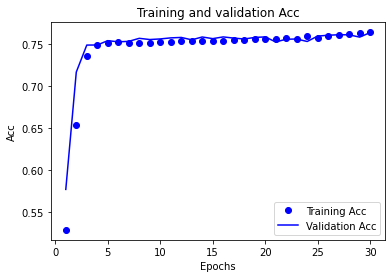

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [23]:
x_test = np.reshape(test_set.values, (len(test_set), 1, 56))
test_pred_nn = (model.predict(x_test) > 0.5).astype("int32")

750/750 [==============================] - 1s 805us/step


In [24]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77     12000
           1       0.78      0.74      0.76     12000

    accuracy                           0.76     24000
   macro avg       0.77      0.76      0.76     24000
weighted avg       0.77      0.76      0.76     24000



## K-NN Classifier


In [106]:
from sklearn.neighbors import KNeighborsClassifier
# use tqdm
import tqdm

k_list = [x for x in range(1, 11)]

knn_list = []
for k in tqdm.tqdm(k_list):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set, train_label)
    knn_list.append(knn.score(test_set, test_label))
    
    # predictions
    prediction_train = knn.predict(train_set)
    prediction_test = knn.predict(test_set)
    
    #accuracy
    accuracy_train = metrics.accuracy_score(train_label, prediction_train)
    accuracy_test = metrics.accuracy_score(test_label, prediction_test)
    
    

  0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [90]:
# print accuracy
print(accuracy_train)
print(accuracy_test)

0.8182637362637363
0.7888717948717948


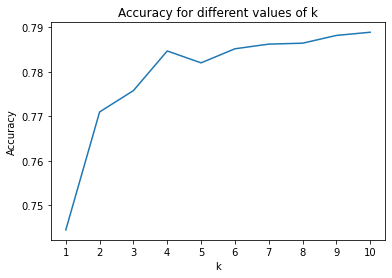

In [91]:
# plot results knn on x axis and accuracy on y axis
plt.plot(k_list, knn_list)
plt.xlabel('k')
plt.ylabel('Accuracy')
#track each k only
plt.xticks(k_list)
plt.title('Accuracy for different values of k')
plt.show()  